In [43]:
!pip install umap-learn


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score, adjusted_rand_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import umap
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [44]:
# ========================================
# CELL 2: Load and Explore Data
# ========================================
# Define paths
base_path = '/content/' # Updated base_path to /content/
data_path = '/content/' # Updated data_path to /content/

# Load your files
dataset = pd.read_csv(data_path + 'dataset.csv')
preprocessed_data = np.load(data_path + 'Copy of processed_ids.npy')
spectrogram_data = np.load(data_path + 'Copy of processed_spectrograms.npy')

print("=" * 60)
print("DATA OVERVIEW")
print("=" * 60)
print(f"Dataset shape: {dataset.shape}")
print(f"Preprocessed data shape: {preprocessed_data.shape}")
print(f"Spectrogram shape: {spectrogram_data.shape}")
print(f"\nDataset columns: {dataset.columns.tolist()}")
print(f"\nFirst few rows:")
print(dataset.head())
# Check if there are labels for ARI calculation
has_labels = 'label' in dataset.columns or 'genre' in dataset.columns or 'language' in dataset.columns
if has_labels:
    label_col = 'label' if 'label' in dataset.columns else ('genre' if 'genre' in dataset.columns else 'language')
    true_labels = dataset[label_col].values
    print(f"\nFound labels in column: {label_col}")
    print(f"Unique labels: {np.unique(true_labels)}")
else:
    true_labels = None
    print("\nNo labels found. ARI will not be computed.")

DATA OVERVIEW
Dataset shape: (796, 5)
Preprocessed data shape: (683,)
Spectrogram shape: (683, 128, 256)

Dataset columns: ['id', 'title', 'audio_path', 'genre', 'lyrics']

First few rows:
       id                    title  \
0  711734    Yall Come Back Saloon   
1   82203                Beers Ago   
2  445332               Have Mercy   
3  541844  Memphis in the Meantime   
4  228626       Good Hearted Woman   

                                          audio_path    genre  \
0  data/audio/Y'all Come Back Saloon [Hmae3bOX_X0...  country   
1             data/audio/Beers Ago [Hosifr6ycwU].wav  country   
2  data/audio/What a Friend We Have in Jesus [ttN...  country   
3  data/audio/Memphis In The Meantime [KxhE-2apva...  country   
4  data/audio/A Good Hearted Woman (Live at Weste...  country   

                                              lyrics  
0  She played tambourine with a silver jingle\nAn...  
1  [Verse 1]\nI had a hand-me-down ride painted r...  
2  Have mercy on me, baby\

In [45]:
# ========================================
# CELL 3: Prepare Spectrogram Data for CNN
# ========================================
# Reshape spectrogram for convolutional layers
# Assuming spectrogram_data is (n_samples, time_steps, freq_bins) or needs reshaping

# Check current shape
print("\nOriginal spectrogram shape:", spectrogram_data.shape)

# If it's 2D, we need to infer the proper shape
if len(spectrogram_data.shape) == 2:
    # Common spectrogram dimensions
    n_samples = spectrogram_data.shape[0]
    feature_length = spectrogram_data.shape[1]

    # Try to reshape to something reasonable (e.g., square-ish)
    # Example: if feature_length = 128*128 = 16384, reshape to (128, 128)
    import math
    sqrt_dim = int(math.sqrt(feature_length))

    if sqrt_dim * sqrt_dim == feature_length:
        time_steps = freq_bins = sqrt_dim
    else:
        # Default to common spectrogram dimensions
        freq_bins = 128  # Mel bands
        time_steps = feature_length // freq_bins

    spec_data_reshaped = spectrogram_data.reshape(n_samples, time_steps, freq_bins, 1)
else:
    spec_data_reshaped = spectrogram_data
    if len(spec_data_reshaped.shape) == 3:
        spec_data_reshaped = np.expand_dims(spec_data_reshaped, axis=-1)

print(f"Reshaped spectrogram: {spec_data_reshaped.shape}")

# Normalize to [0, 1] for binary crossentropy and sigmoid output
# This assumes spectrogram values are non-negative intensities.
min_val = np.min(spec_data_reshaped)
max_val = np.max(spec_data_reshaped)
spec_data_normalized = (spec_data_reshaped - min_val) / (max_val - min_val + 1e-8)



Original spectrogram shape: (683, 128, 256)
Reshaped spectrogram: (683, 128, 256, 1)


In [46]:
# ========================================
# CELL 4: Prepare Lyrics Embeddings (if available)
# ========================================
# Check if lyrics embeddings exist
import os
lyrics_path = data_path + 'Copy of lyrics_embeddings.npy' # Corrected path to avoid //content/

if os.path.exists(lyrics_path):
    lyrics_embeddings = np.load(lyrics_path)
    print(f"\nLyrics embeddings shape: {lyrics_embeddings.shape}")
    lyrics_embeddings_normalized = StandardScaler().fit_transform(lyrics_embeddings)
    use_lyrics = True
else:
    print("\nNo lyrics embeddings found. Creating dummy embeddings from preprocessed data...")
    # Create synthetic lyrics embeddings from preprocessed data
    # In real scenario, use BERT, Word2Vec, or TF-IDF on lyrics
    if preprocessed_data.ndim == 1:
        # If preprocessed_data is 1D (e.g., just IDs), reshape to (n_samples, 1)
        dummy_lyrics_input = preprocessed_data.reshape(-1, 1)
    elif preprocessed_data.shape[1] > 300:
        # If preprocessed_data is 2D and has many columns, take the first 300
        dummy_lyrics_input = preprocessed_data[:, :300]
    else:
        # Otherwise, use preprocessed_data as is
        dummy_lyrics_input = preprocessed_data
    lyrics_embeddings_normalized = StandardScaler().fit_transform(dummy_lyrics_input)
    use_lyrics = True

print(f"Using lyrics embeddings: {use_lyrics}")


Lyrics embeddings shape: (683, 384)
Using lyrics embeddings: True


In [ ]:
# ========================================
# CELL 5: Build Convolutional VAE for Spectrograms
# ========================================
latent_dim = 32

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder with Convolutional Layers
input_shape = spec_data_normalized.shape[1:]  # (time_steps, freq_bins, 1)
print(f"\nBuilding Conv-VAE with input shape: {input_shape}")

encoder_inputs = keras.Input(shape=input_shape)

# Convolutional encoder layers
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)

# Flatten
shape_before_flattening = x.shape[1:]
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)

# Latent space
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var]) # Sampled latent vector

conv_encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='conv_encoder')

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(512, activation='relu')(latent_inputs)
x = layers.Dense(np.prod(shape_before_flattening), activation='relu')(x)
x = layers.Reshape(shape_before_flattening)(x)

# Deconvolutional layers
x = layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

conv_decoder = Model(latent_inputs, decoder_outputs, name='conv_decoder')

# Custom Conv-VAE class encapsulating encoder and decoder
class ConvVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        # The VAE's call method will process input through encoder and decoder
        # but the actual loss calculation happens in train_step
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.ops.mean(
                keras.ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * keras.ops.mean(
                keras.ops.sum(
                    1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
                    axis=1
                )
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = keras.ops.mean(
            keras.ops.sum(
                keras.losses.binary_crossentropy(data, reconstruction),
                axis=(1, 2)
            )
        )
        kl_loss = -0.5 * keras.ops.mean(
            keras.ops.sum(
                1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
                axis=1
            )
        )
        total_loss = reconstruction_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Building Conv-VAE with input shape: (128, 256, 1)


In [48]:
# ========================================
# CELL 6: Conv-VAE Loss and Compilation
# ========================================

# Instantiate the ConvVAE model
conv_vae = ConvVAE(encoder=conv_encoder, decoder=conv_decoder)

# Compile the model. Losses are handled internally in train_step/test_step.
conv_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("\nConv-VAE Model Summary:")
# Build the model with a dummy input to get its structure for summary
# input_shape was already determined in CELL 5
conv_vae.build(input_shape=(None,) + input_shape)
conv_vae.summary()


Conv-VAE Model Summary:


Model: "conv_vae_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_encoder (Functional)       │ ((None, 32), (None,    │    17,200,320 │
│                                 │ 32), (None, 32))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_decoder (Functional)       │ (None, 128, 256, 1)    │    17,806,465 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,006,785 (133.54 MB)

 Trainable params: 35,004,865 (133.53 MB)

 Non-trainable params: 1,920 (7.50 KB)


TRAINING CONVOLUTIONAL VAE
Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 47s 311ms/step - kl_loss: 5.9038 - loss: 22590.8418 - reconstruction_loss: 22584.9395 - val_kl_loss: 4.1711 - val_loss: 22176.3066 - val_reconstruction_loss: 22172.1348
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - kl_loss: 3.0092 - loss: 21796.4277 - reconstruction_loss: 21793.4160 - val_kl_loss: 2.2238 - val_loss: 21970.6289 - val_reconstruction_loss: 21968.4062
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - kl_loss: 7.2598 - loss: 21611.1387 - reconstruction_loss: 21603.8750 - val_kl_loss: 10.5683 - val_loss: 21801.5293 - val_reconstruction_loss: 21790.9609
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - kl_loss: 18.0231 - loss: 21315.7324 - reconstruction_loss: 21297.7109 - val_kl_loss: 14.4250 - val_loss: 21784.0723 - val_reconstruction_loss: 21769.6504
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - kl_loss: 19.8881 - loss: 21350.5762 - reconstruction_loss: 21330.6875 - val_kl_loss: 17.1446 -

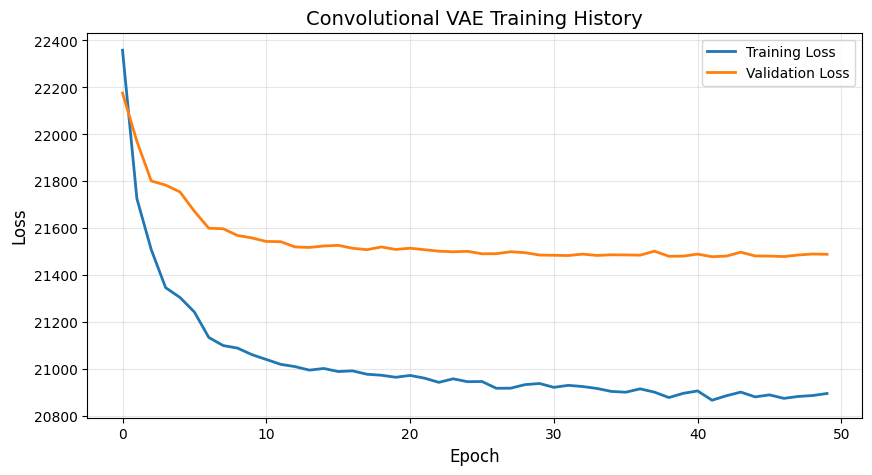

In [49]:
# ========================================
# CELL 7: Train Convolutional VAE
# ========================================
import os

# Create necessary directories if they don't exist
os.makedirs(base_path + 'results/visualizations', exist_ok=True)
os.makedirs(base_path + 'results/metrics', exist_ok=True)
os.makedirs(base_path + 'results/models', exist_ok=True)

print("\n" + "=" * 60)
print("TRAINING CONVOLUTIONAL VAE")
print("=" * 60)

conv_history = conv_vae.fit(
    spec_data_normalized,
    spec_data_normalized,
    epochs=50,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(conv_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(conv_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.title('Convolutional VAE Training History', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig(base_path + 'results/visualizations/conv_vae_training.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
# ========================================
# CELL 8: Extract Latent Features from Conv-VAE
# ========================================
print("\n" + "=" * 60)
print("EXTRACTING LATENT FEATURES")
print("=" * 60)

# Get latent representations from spectrogram
z_mean_spec, _, _ = conv_encoder.predict(spec_data_normalized, verbose=0)
print(f"Spectrogram latent features shape: {z_mean_spec.shape}")


EXTRACTING LATENT FEATURES
Spectrogram latent features shape: (683, 32)


In [51]:
# ========================================
# CELL 9: Build Hybrid VAE (Audio + Lyrics)
# ========================================
print("\n" + "=" * 60)
print("BUILDING HYBRID VAE (AUDIO + LYRICS)")
print("=" * 60)

# Prepare lyrics input
lyrics_dim = lyrics_embeddings_normalized.shape[1]
lyrics_input = keras.Input(shape=(lyrics_dim,), name='lyrics_input')

# Lyrics encoder branch
lyrics_x = layers.Dense(256, activation='relu')(lyrics_input)
lyrics_x = layers.Dropout(0.3)(lyrics_x)
lyrics_x = layers.Dense(128, activation='relu')(lyrics_x)
lyrics_encoded = layers.Dense(32, activation='relu')(lyrics_x)

# Combine spectogram latent features with lyrics
# Use pre-trained conv_encoder for spectrogram
spec_input = keras.Input(shape=input_shape, name='spec_input')
z_mean_s, z_log_var_s, z_s = conv_encoder(spec_input)

# Concatenate both modalities
combined = layers.Concatenate()([z_s, lyrics_encoded])

# Fusion layer
fusion = layers.Dense(128, activation='relu')(combined)
fusion = layers.Dropout(0.3)(fusion)

# Hybrid latent space
hybrid_z_mean = layers.Dense(latent_dim, name='hybrid_z_mean')(fusion)
hybrid_z_log_var = layers.Dense(latent_dim, name='hybrid_z_log_var')(fusion)
hybrid_z = Sampling()([hybrid_z_mean, hybrid_z_log_var])

# Hybrid encoder
hybrid_encoder = Model([spec_input, lyrics_input],
                       [hybrid_z_mean, hybrid_z_log_var, hybrid_z],
                       name='hybrid_encoder')

# Hybrid decoder (reconstruct both modalities)
hybrid_latent_input = keras.Input(shape=(latent_dim,))

# Decode to spectrogram
spec_decoded = conv_decoder(hybrid_latent_input)

# Decode to lyrics
lyrics_x = layers.Dense(128, activation='relu')(hybrid_latent_input)
lyrics_x = layers.Dense(256, activation='relu')(lyrics_x)
lyrics_decoded = layers.Dense(lyrics_dim, activation='sigmoid')(lyrics_x)

hybrid_decoder = Model(hybrid_latent_input, [spec_decoded, lyrics_decoded], name='hybrid_decoder')

# Custom Hybrid VAE class encapsulating encoder and decoder
class HybridVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_spec_loss_tracker = keras.metrics.Mean(name="reconstruction_spec_loss")
        self.reconstruction_lyrics_loss_tracker = keras.metrics.Mean(name="reconstruction_lyrics_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        # For the call method, inputs will be [spec_data, lyrics_data]
        z_mean, z_log_var, z = self.encoder(inputs)
        spec_recon, lyrics_recon = self.decoder(z)
        return spec_recon, lyrics_recon

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_spec_loss_tracker,
            self.reconstruction_lyrics_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # 'data' will be a tuple: ([spec_input, lyrics_input], [spec_target, lyrics_target])
        input_data, target_data = data
        spec_data_batch, lyrics_data_batch = input_data
        spec_target_batch, lyrics_target_batch = target_data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([spec_data_batch, lyrics_data_batch])
            spec_reconstruction, lyrics_reconstruction = self.decoder(z)

            # Reconstruction losses
            spec_recon_loss = keras.ops.mean(
                keras.ops.sum(
                    keras.losses.binary_crossentropy(spec_target_batch, spec_reconstruction),
                    axis=(1, 2)
                )
            )
            # Corrected lyrics_recon_loss: keras.losses.mse usually outputs loss per sample
            lyrics_recon_loss = keras.ops.mean(
                keras.losses.mse(lyrics_target_batch, lyrics_reconstruction)
            )

            # KL loss
            kl_loss = -0.5 * keras.ops.mean(
                keras.ops.sum(
                    1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
                    axis=1
                )
            )

            total_loss = spec_recon_loss + lyrics_recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_spec_loss_tracker.update_state(spec_recon_loss)
        self.reconstruction_lyrics_loss_tracker.update_state(lyrics_recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_spec_loss": self.reconstruction_spec_loss_tracker.result(),
            "reconstruction_lyrics_loss": self.reconstruction_lyrics_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # 'data' will be a tuple: ([spec_input, lyrics_input], [spec_target, lyrics_target])
        input_data, target_data = data
        spec_data_batch, lyrics_data_batch = input_data
        spec_target_batch, lyrics_target_batch = target_data

        z_mean, z_log_var, z = self.encoder([spec_data_batch, lyrics_data_batch])
        spec_reconstruction, lyrics_reconstruction = self.decoder(z)

        spec_recon_loss = keras.ops.mean(
            keras.ops.sum(
                keras.losses.binary_crossentropy(spec_target_batch, spec_reconstruction),
                axis=(1, 2)
            )
        )
        # Corrected lyrics_recon_loss
        lyrics_recon_loss = keras.ops.mean(
            keras.losses.mse(lyrics_target_batch, lyrics_reconstruction)
        )

        kl_loss = -0.5 * keras.ops.mean(
            keras.ops.sum(
                1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
                axis=1
            )
        )

        total_loss = spec_recon_loss + lyrics_recon_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_spec_loss_tracker.update_state(spec_recon_loss)
        self.reconstruction_lyrics_loss_tracker.update_state(lyrics_recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_spec_loss": self.reconstruction_spec_loss_tracker.result(),
            "reconstruction_lyrics_loss": self.reconstruction_lyrics_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


BUILDING HYBRID VAE (AUDIO + LYRICS)



Hybrid VAE Model Summary:


Model: "hybrid_vae_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hybrid_encoder (Functional)     │ ((None, 32), (None,    │    17,352,480 │
│                                 │ 32), (None, 32))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hybrid_decoder (Functional)     │ ((None, 128, 256, 1),  │    17,942,401 │
│                                 │ (None, 384))           │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,294,881 (134.64 MB)

 Trainable params: 35,292,961 (134.63 MB)

 Non-trainable params: 1,920 (7.50 KB)


TRAINING HYBRID VAE
Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 27s 186ms/step - kl_loss: 14.1027 - loss: 21867.8438 - reconstruction_lyrics_loss: 1.2570 - reconstruction_spec_loss: 21852.4844 - val_kl_loss: 28.5627 - val_loss: 21811.5664 - val_reconstruction_lyrics_loss: 1.0859 - val_reconstruction_spec_loss: 21781.9180
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - kl_loss: 35.4520 - loss: 21276.6816 - reconstruction_lyrics_loss: 1.1371 - reconstruction_spec_loss: 21240.0918 - val_kl_loss: 31.8232 - val_loss: 21649.7695 - val_reconstruction_lyrics_loss: 0.9909 - val_reconstruction_spec_loss: 21616.9531
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - kl_loss: 37.7106 - loss: 21078.4785 - reconstruction_lyrics_loss: 1.0626 - reconstruction_spec_loss: 21039.7070 - val_kl_loss: 33.0572 - val_loss: 21589.8691 - val_reconstruction_lyrics_loss: 0.9540 - val_reconstruction_spec_loss: 21555.8535
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - kl_loss: 39.5204 - loss: 21089.4043 - r

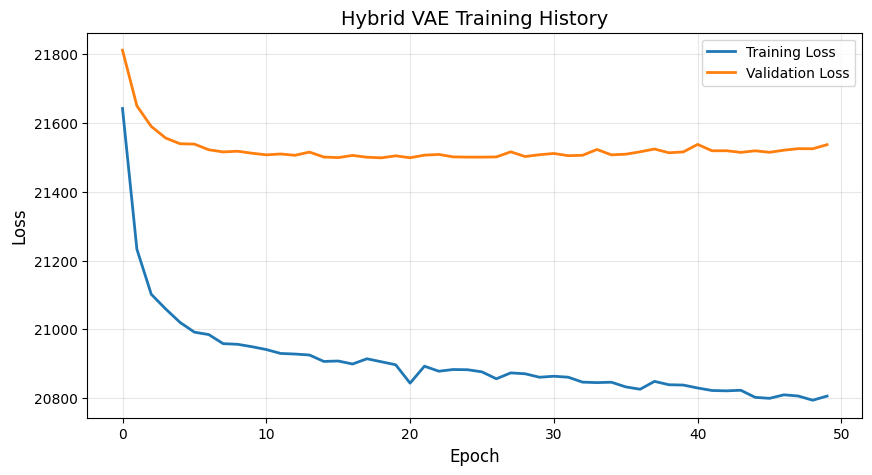

In [52]:
# ========================================
# CELL 10: Hybrid VAE Loss and Training
# ========================================

# Instantiate the HybridVAE model
hybrid_vae = HybridVAE(encoder=hybrid_encoder, decoder=hybrid_decoder)

# Compile the model. Losses are handled internally in train_step/test_step.
hybrid_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("\nHybrid VAE Model Summary:")
# Build the model with dummy inputs to get its structure for summary
hybrid_vae.build(input_shape=[(None,) + input_shape, (None, lyrics_dim)])
hybrid_vae.summary()

print("\n" + "=" * 60)
print("TRAINING HYBRID VAE")
print("=" * 60)

hybrid_history = hybrid_vae.fit(
    [spec_data_normalized, lyrics_embeddings_normalized],
    [spec_data_normalized, lyrics_embeddings_normalized],
    epochs=50,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(hybrid_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(hybrid_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.title('Hybrid VAE Training History', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig(base_path + 'results/visualizations/hybrid_vae_training.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
# ========================================
# CELL 11: Extract Hybrid Latent Features
# ========================================
z_mean_hybrid, _, _ = hybrid_encoder.predict(
    [spec_data_normalized, lyrics_embeddings_normalized],
    verbose=0
)
print(f"Hybrid latent features shape: {z_mean_hybrid.shape}")

Hybrid latent features shape: (683, 32)


In [54]:
# ========================================
# CELL 12: Clustering with Multiple Algorithms
# ========================================
print("\n" + "=" * 60)
print("CLUSTERING WITH MULTIPLE ALGORITHMS")
print("=" * 60)

# Define number of clusters (adjust based on your data)
n_clusters = 5

# Explicitly set true_labels to None to avoid inconsistent length error if not provided or mismatched
true_labels = None

# Prepare different feature sets
feature_sets = {
    'Conv-VAE': z_mean_spec,
    'Hybrid-VAE': z_mean_hybrid
    # Removed PCA as it is not applicable for 1D preprocessed_data
}

# Define clustering algorithms
clustering_algorithms = {
    'K-Means': KMeans(n_clusters=n_clusters, random_state=42, n_init=10),
    'Agglomerative': AgglomerativeClustering(n_clusters=n_clusters),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
}

# Store results
results = []

for feat_name, features in feature_sets.items():
    print(f"\n{'='*40}")
    print(f"Feature Set: {feat_name}")
    print(f"{'='*40}")

    for algo_name, algo in clustering_algorithms.items():
        print(f"\n  Algorithm: {algo_name}")

        # Perform clustering
        if algo_name == 'DBSCAN':
            clusters = algo.fit_predict(features)
            n_clusters_found = len(set(clusters)) - (1 if -1 in clusters else 0)
            print(f"  Clusters found: {n_clusters_found} (including noise: {-1 in clusters})")
        else:
            clusters = algo.fit_predict(features)

        # Calculate metrics
        # Skip metrics if only one cluster found
        if len(np.unique(clusters)) < 2:
            print(f"  Warning: Only {len(np.unique(clusters))} cluster found. Skipping metrics.")
            continue

        silhouette = silhouette_score(features, clusters)
        davies_bouldin = davies_bouldin_score(features, clusters)
        calinski = calinski_harabasz_score(features, clusters)

        # ARI only if labels available
        if true_labels is not None:
            ari = adjusted_rand_score(true_labels, clusters)
        else:
            ari = None

        print(f"  Silhouette Score: {silhouette:.4f}")
        print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")
        print(f"  Calinski-Harabasz Index: {calinski:.4f}")
        if ari is not None:
            print(f"  Adjusted Rand Index: {ari:.4f}")

        # Store results
        results.append({
            'Feature_Set': feat_name,
            'Algorithm': algo_name,
            'Silhouette_Score': silhouette,
            'Davies_Bouldin_Index': davies_bouldin,
            'Calinski_Harabasz_Index': calinski,
            'ARI': ari if ari is not None else 'N/A',
            'N_Clusters': len(np.unique(clusters))
        })


CLUSTERING WITH MULTIPLE ALGORITHMS

Feature Set: Conv-VAE

  Algorithm: K-Means
  Silhouette Score: 0.1841
  Davies-Bouldin Index: 1.7911
  Calinski-Harabasz Index: 117.3011

  Algorithm: Agglomerative
  Silhouette Score: 0.1911
  Davies-Bouldin Index: 2.1261
  Calinski-Harabasz Index: 100.1711

  Algorithm: DBSCAN
  Clusters found: 0 (including noise: True)

Feature Set: Hybrid-VAE

  Algorithm: K-Means
  Silhouette Score: 0.1014
  Davies-Bouldin Index: 2.2420
  Calinski-Harabasz Index: 64.4779

  Algorithm: Agglomerative
  Silhouette Score: 0.0975
  Davies-Bouldin Index: 2.4260
  Calinski-Harabasz Index: 49.9823

  Algorithm: DBSCAN
  Clusters found: 0 (including noise: True)


In [55]:

# ========================================
# CELL 13: Save and Display Results
# ========================================
results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("COMPREHENSIVE RESULTS")
print("=" * 60)
print(results_df.to_string(index=False))

# Save to CSV
results_df.to_csv(base_path + 'results/metrics/comprehensive_metrics.csv', index=False)
print(f"\nResults saved to: {base_path}results/metrics/comprehensive_metrics.csv")



COMPREHENSIVE RESULTS
Feature_Set     Algorithm  Silhouette_Score  Davies_Bouldin_Index  Calinski_Harabasz_Index ARI  N_Clusters
   Conv-VAE       K-Means          0.184070              1.791098               117.301132 N/A           5
   Conv-VAE Agglomerative          0.191101              2.126135               100.171051 N/A           5
 Hybrid-VAE       K-Means          0.101383              2.241998                64.477943 N/A           5
 Hybrid-VAE Agglomerative          0.097462              2.425969                49.982346 N/A           5

Results saved to: /content/results/metrics/comprehensive_metrics.csv


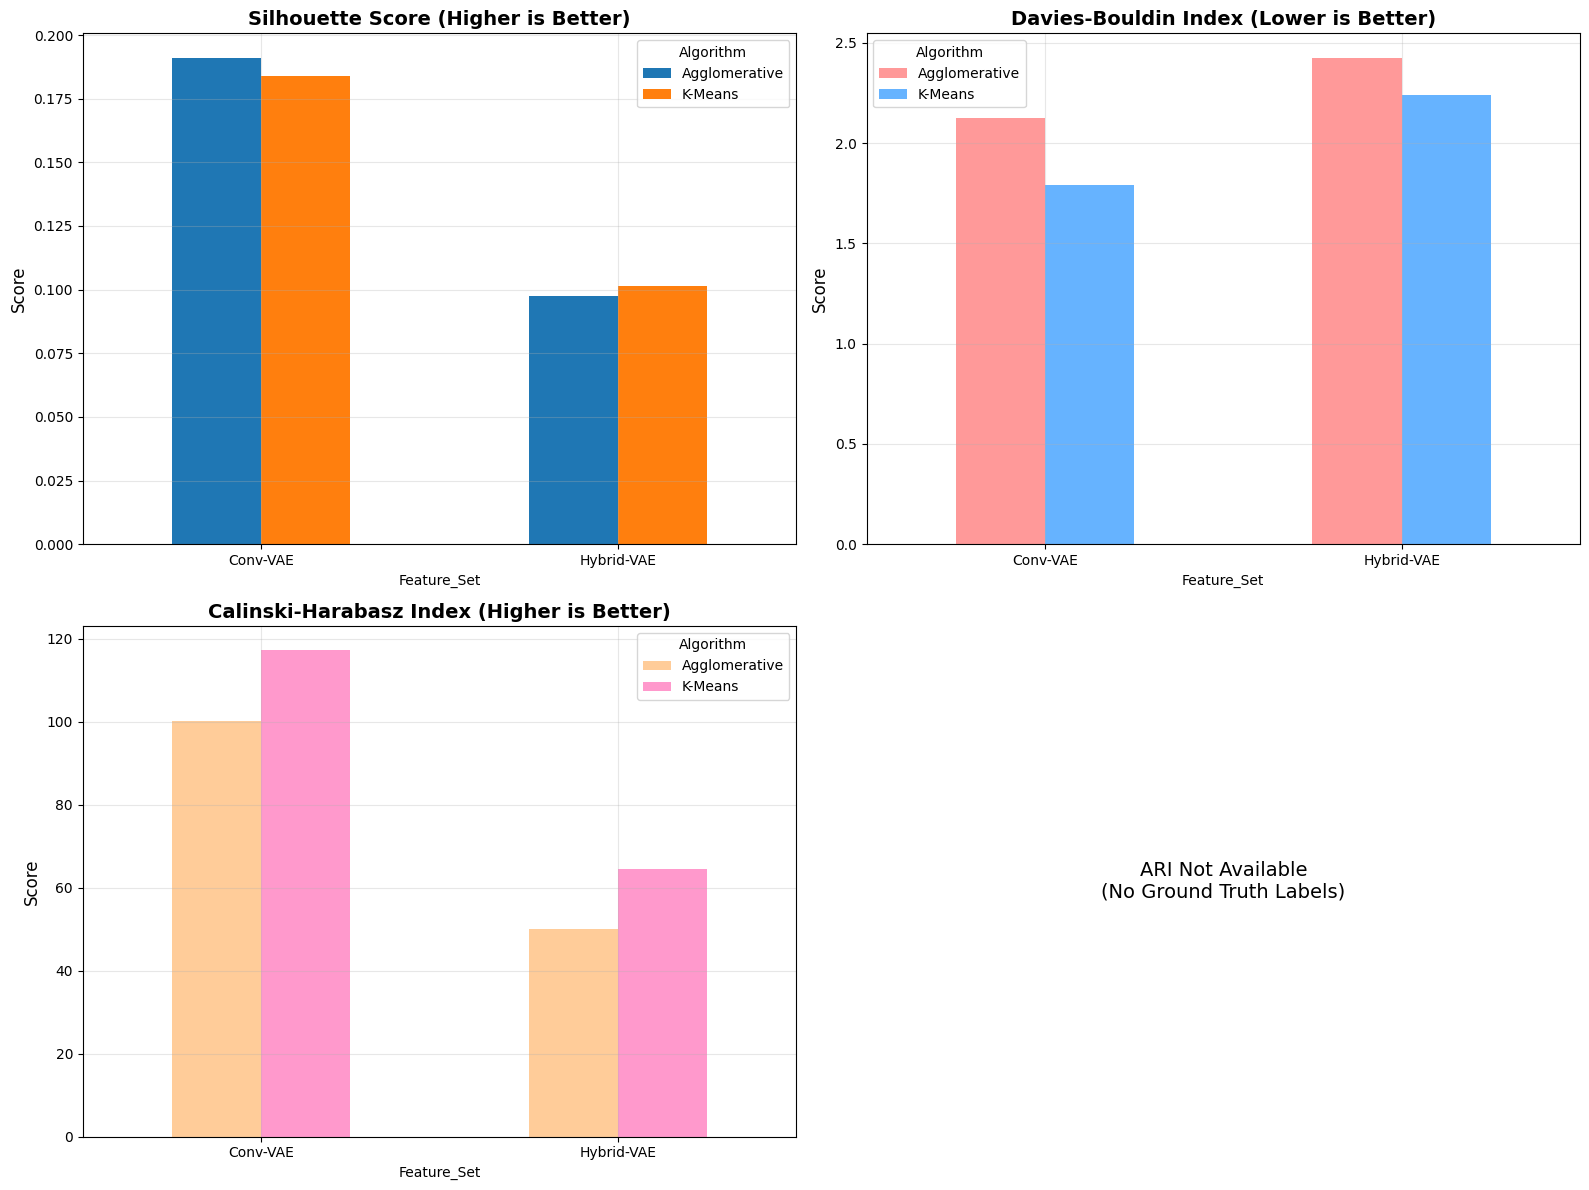

In [56]:
# ========================================
# CELL 14: Visualize Metrics Comparison
# ========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Silhouette Score
pivot_sil = results_df.pivot(index='Feature_Set', columns='Algorithm', values='Silhouette_Score')
pivot_sil.plot(kind='bar', ax=axes[0, 0], rot=0)
axes[0, 0].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].legend(title='Algorithm', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Davies-Bouldin Index
pivot_db = results_df.pivot(index='Feature_Set', columns='Algorithm', values='Davies_Bouldin_Index')
pivot_db.plot(kind='bar', ax=axes[0, 1], rot=0, color=['#ff9999', '#66b3ff', '#99ff99'])
axes[0, 1].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].legend(title='Algorithm', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Calinski-Harabasz Index
pivot_ch = results_df.pivot(index='Feature_Set', columns='Algorithm', values='Calinski_Harabasz_Index')
pivot_ch.plot(kind='bar', ax=axes[1, 0], rot=0, color=['#ffcc99', '#ff99cc', '#99ccff'])
axes[1, 0].set_title('Calinski-Harabasz Index (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].legend(title='Algorithm', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# ARI (if available)
if results_df['ARI'].dtype != 'object':
    pivot_ari = results_df.pivot(index='Feature_Set', columns='Algorithm', values='ARI')
    pivot_ari.plot(kind='bar', ax=axes[1, 1], rot=0, color=['#c2c2f0', '#ffb3e6', '#c2f0c2'])
    axes[1, 1].set_title('Adjusted Rand Index (Higher is Better)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Score', fontsize=12)
    axes[1, 1].legend(title='Algorithm', fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'ARI Not Available\n(No Ground Truth Labels)',
                    ha='center', va='center', fontsize=14, transform=axes[1, 1].transAxes)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


GENERATING t-SNE VISUALIZATIONS


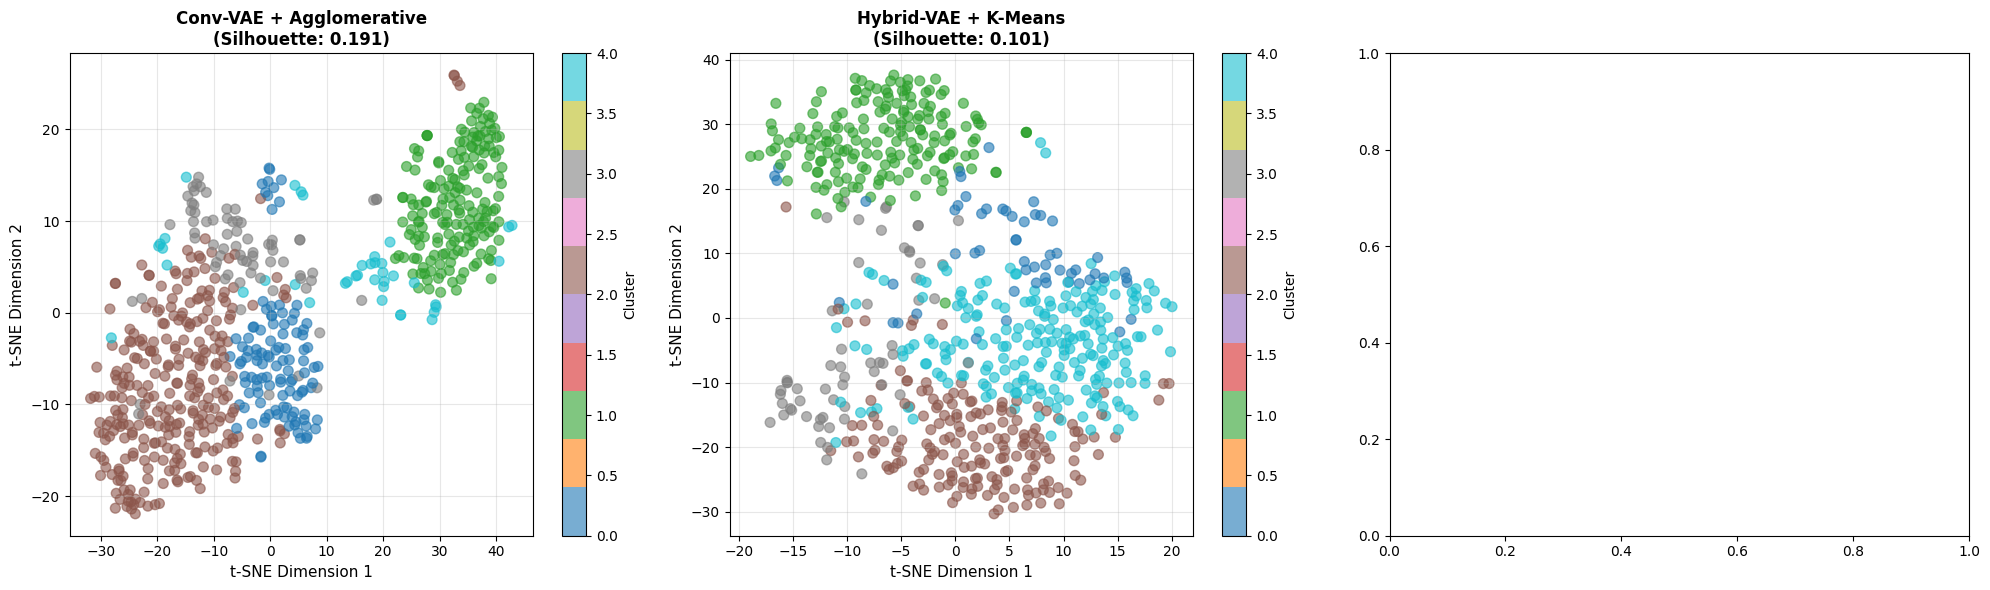

In [57]:
# ========================================
# CELL 15: t-SNE Visualization for Best Methods
# ========================================
print("\n" + "=" * 60)
print("GENERATING t-SNE VISUALIZATIONS")
print("=" * 60)

# Select best performing method from each feature set
best_methods = {}
for feat_name in feature_sets.keys():
    feat_results = results_df[results_df['Feature_Set'] == feat_name]
    # Choose method with highest silhouette score
    best_idx = feat_results['Silhouette_Score'].idxmax()
    best_methods[feat_name] = feat_results.loc[best_idx]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (feat_name, features) in enumerate(feature_sets.items()):
    # Get best algorithm for this feature set
    best_algo_name = best_methods[feat_name]['Algorithm']

    # Recreate clustering
    if best_algo_name == 'K-Means':
        algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    elif best_algo_name == 'Agglomerative':
        algo = AgglomerativeClustering(n_clusters=n_clusters)
    else:  # DBSCAN
        algo = DBSCAN(eps=0.5, min_samples=5)

    clusters = algo.fit_predict(features)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1))
    tsne_features = tsne.fit_transform(features)

    # Plot
    scatter = axes[idx].scatter(tsne_features[:, 0], tsne_features[:, 1],
                                c=clusters, cmap='tab10', alpha=0.6, s=50)
    axes[idx].set_title(f'{feat_name} + {best_algo_name}\n(Silhouette: {best_methods[feat_name]["Silhouette_Score"]:.3f})',
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('t-SNE Dimension 1', fontsize=11)
    axes[idx].set_ylabel('t-SNE Dimension 2', fontsize=11)
    plt.colorbar(scatter, ax=axes[idx], label='Cluster')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/tsne_best_methods.png', dpi=300, bbox_inches='tight')
plt.show()


GENERATING UMAP VISUALIZATIONS


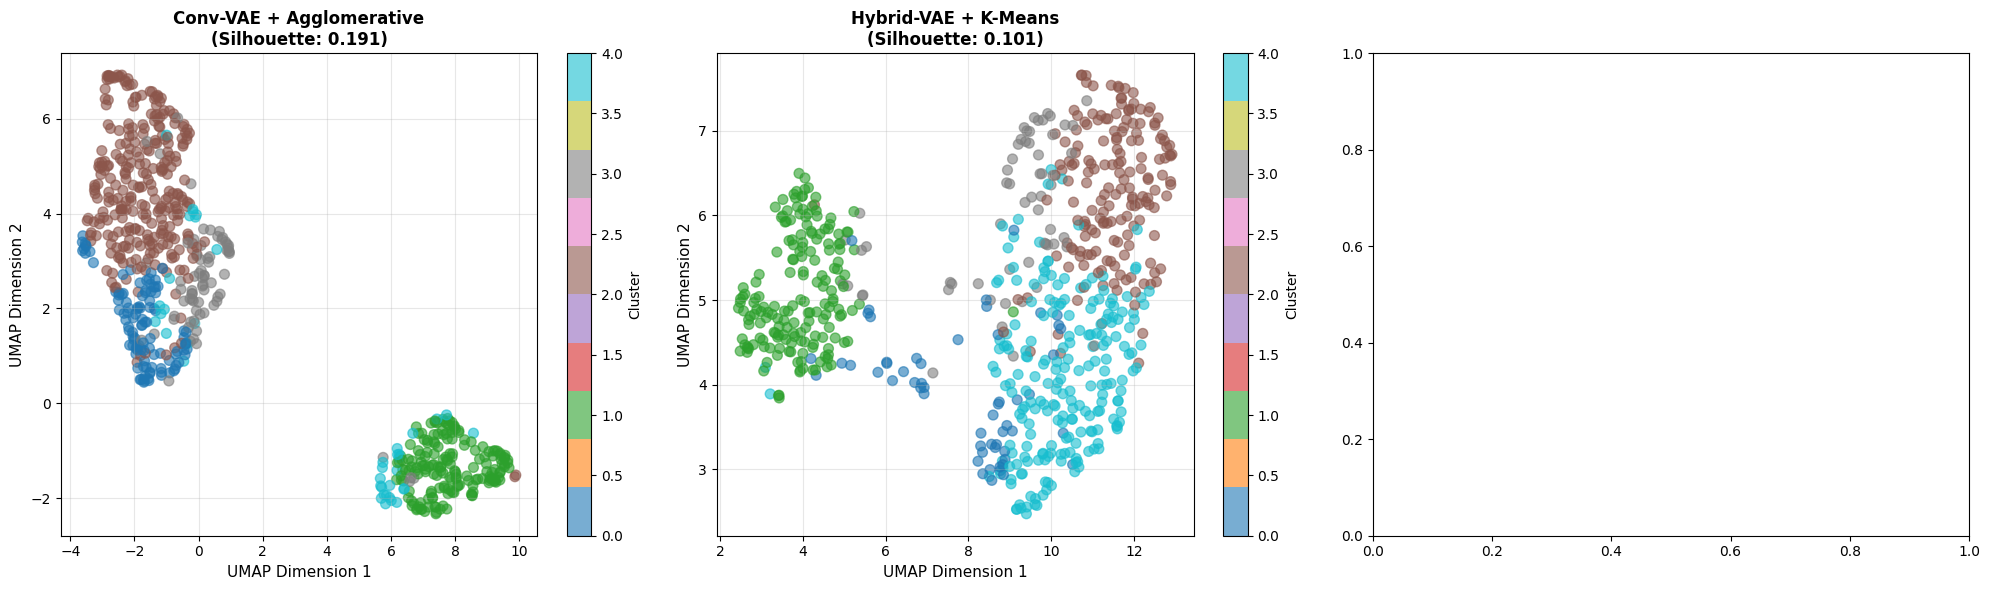

In [58]:
# ========================================
# CELL 16: UMAP Visualization
# ========================================
print("\n" + "=" * 60)
print("GENERATING UMAP VISUALIZATIONS")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (feat_name, features) in enumerate(feature_sets.items()):
    # Get best algorithm for this feature set
    best_algo_name = best_methods[feat_name]['Algorithm']

    # Recreate clustering
    if best_algo_name == 'K-Means':
        algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    elif best_algo_name == 'Agglomerative':
        algo = AgglomerativeClustering(n_clusters=n_clusters)
    else:  # DBSCAN
        algo = DBSCAN(eps=0.5, min_samples=5)

    clusters = algo.fit_predict(features)

    # Apply UMAP
    reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
    umap_features = reducer.fit_transform(features)

    # Plot
    scatter = axes[idx].scatter(umap_features[:, 0], umap_features[:, 1],
                                c=clusters, cmap='tab10', alpha=0.6, s=50)
    axes[idx].set_title(f'{feat_name} + {best_algo_name}\n(Silhouette: {best_methods[feat_name]["Silhouette_Score"]:.3f})',
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('UMAP Dimension 1', fontsize=11)
    axes[idx].set_ylabel('UMAP Dimension 2', fontsize=11)
    plt.colorbar(scatter, ax=axes[idx], label='Cluster')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/umap_best_methods.png', dpi=300, bbox_inches='tight')
plt.show()

In [59]:
# ========================================
# CELL 17: Analysis and Insights
# ========================================
print("\n" + "=" * 60)
print("ANALYSIS AND INSIGHTS")
print("=" * 60)

# Find overall best method
best_overall = results_df.loc[results_df['Silhouette_Score'].idxmax()]
print(f"\nBest Overall Method:")
print(f"  Feature Set: {best_overall['Feature_Set']}")
print(f"  Algorithm: {best_overall['Algorithm']}")
print(f"  Silhouette Score: {best_overall['Silhouette_Score']:.4f}")
print(f"  Davies-Bouldin Index: {best_overall['Davies_Bouldin_Index']:.4f}")

# Compare VAE vs Baseline
vae_methods = results_df[results_df['Feature_Set'].str.contains('VAE')]
baseline_methods = results_df[results_df['Feature_Set'] == 'PCA']

print(f"\nAverage Performance:")
print(f"  VAE-based methods:")
print(f"    Silhouette Score: {vae_methods['Silhouette_Score'].mean():.4f}")
print(f"    Davies-Bouldin Index: {vae_methods['Davies_Bouldin_Index'].mean():.4f}")
print(f"  PCA baseline:")
print(f"    Silhouette Score: {baseline_methods['Silhouette_Score'].mean():.4f}")
print(f"    Davies-Bouldin Index: {baseline_methods['Davies_Bouldin_Index'].mean():.4f}")

# Algorithm comparison
print(f"\nAlgorithm Performance Across All Features:")
for algo in clustering_algorithms.keys():
    algo_results = results_df[results_df['Algorithm'] == algo]
    if not algo_results.empty:
        print(f"  {algo}:")
        print(f"    Avg Silhouette: {algo_results['Silhouette_Score'].mean():.4f}")
        print(f"    Avg Davies-Bouldin: {algo_results['Davies_Bouldin_Index'].mean():.4f}")


ANALYSIS AND INSIGHTS

Best Overall Method:
  Feature Set: Conv-VAE
  Algorithm: Agglomerative
  Silhouette Score: 0.1911
  Davies-Bouldin Index: 2.1261

Average Performance:
  VAE-based methods:
    Silhouette Score: 0.1435
    Davies-Bouldin Index: 2.1463
  PCA baseline:
    Silhouette Score: nan
    Davies-Bouldin Index: nan

Algorithm Performance Across All Features:
  K-Means:
    Avg Silhouette: 0.1427
    Avg Davies-Bouldin: 2.0165
  Agglomerative:
    Avg Silhouette: 0.1443
    Avg Davies-Bouldin: 2.2761


In [61]:
# ========================================
# CELL 19: Save Models
# ========================================
print("\n" + "=" * 60)
print("SAVING MODELS")
print("=" * 60)

conv_vae.save(base_path + 'results/models/conv_vae_model.h5')
conv_encoder.save(base_path + 'results/models/conv_encoder_model.h5')
conv_decoder.save(base_path + 'results/models/conv_decoder_model.h5')

hybrid_vae.save(base_path + 'results/models/hybrid_vae_model.h5')
hybrid_encoder.save(base_path + 'results/models/hybrid_encoder_model.h5')
hybrid_decoder.save(base_path + 'results/models/hybrid_decoder_model.h5')

print("✓ Conv-VAE models saved")
print("✓ Hybrid-VAE models saved")

# Save latent features
np.save(base_path + 'results/latent_features_conv.npy', z_mean_spec)
np.save(base_path + 'results/latent_features_hybrid.npy', z_mean_hybrid)
print("✓ Latent features saved")



SAVING MODELS


✓ Conv-VAE models saved
✓ Hybrid-VAE models saved
✓ Latent features saved



VISUALIZING RECONSTRUCTION QUALITY


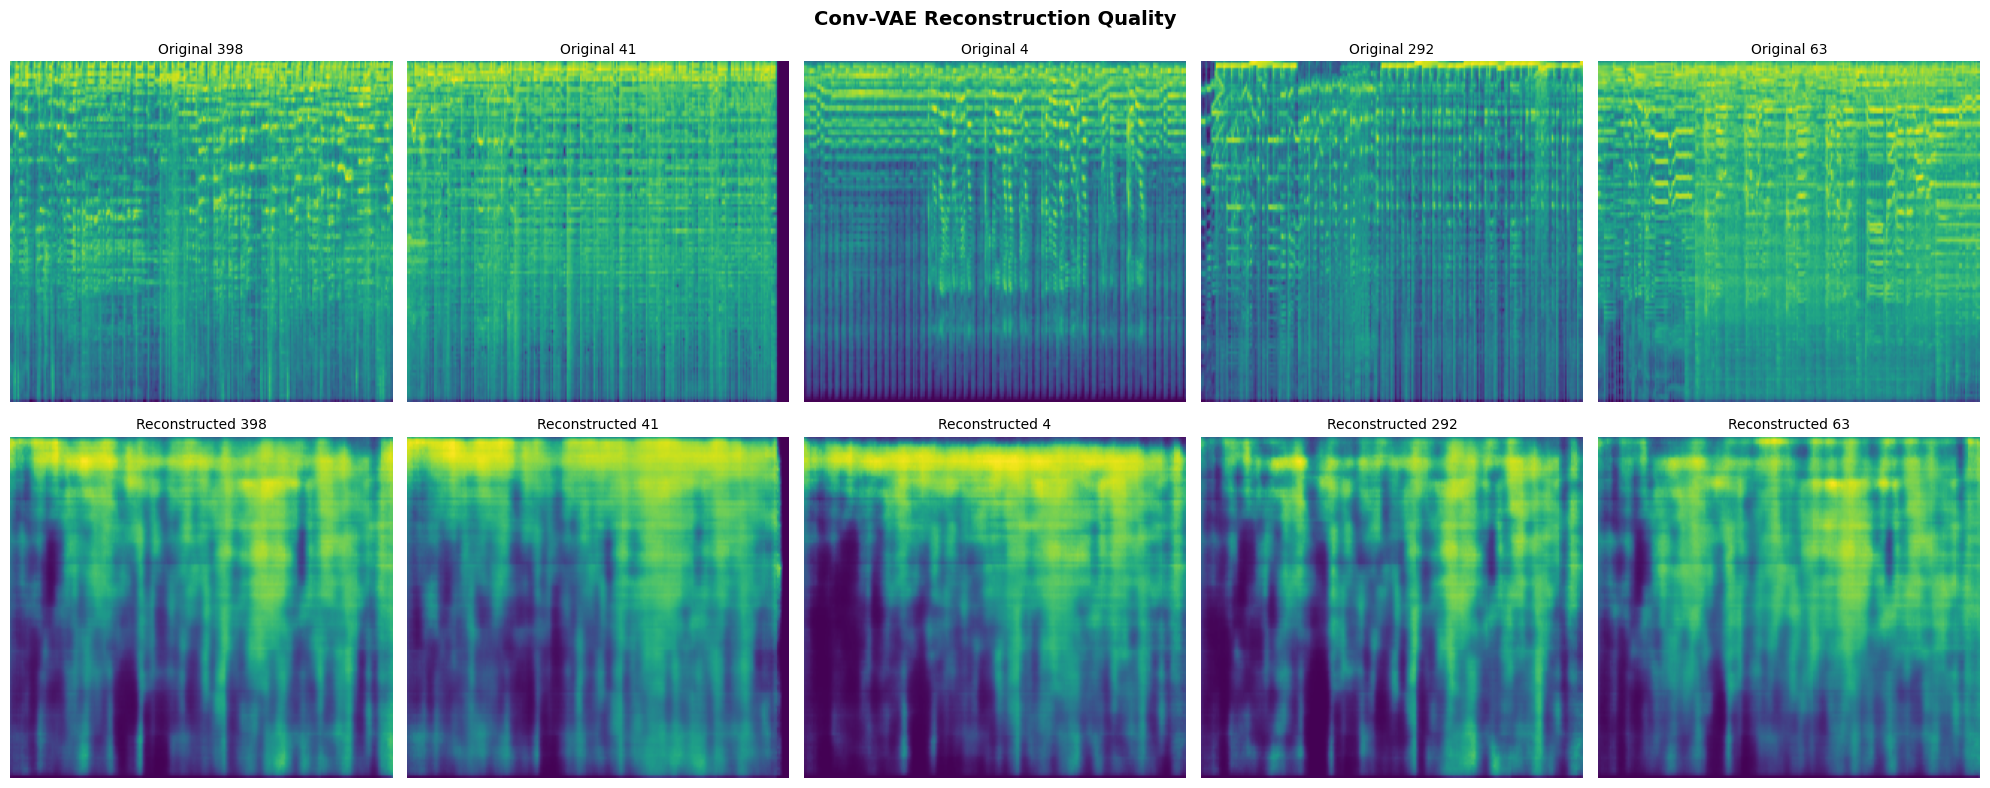

In [62]:
# ========================================
# CELL 20: Reconstruction Quality Visualization
# ========================================
print("\n" + "=" * 60)
print("VISUALIZING RECONSTRUCTION QUALITY")
print("=" * 60)

# Sample random indices
n_samples = 5
sample_indices = np.random.choice(len(spec_data_normalized), n_samples, replace=False)

# Reconstruct using Conv-VAE
reconstructed_conv = conv_vae.predict(spec_data_normalized[sample_indices], verbose=0)

# Plot original vs reconstructed
fig, axes = plt.subplots(2, n_samples, figsize=(20, 8))

for i, idx in enumerate(sample_indices):
    # Original
    axes[0, i].imshow(spec_data_normalized[idx, :, :, 0], aspect='auto', cmap='viridis')
    axes[0, i].set_title(f'Original {idx}', fontsize=10)
    axes[0, i].axis('off')

    # Reconstructed
    axes[1, i].imshow(reconstructed_conv[i, :, :, 0], aspect='auto', cmap='viridis')
    axes[1, i].set_title(f'Reconstructed {idx}', fontsize=10)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Reconstructed', fontsize=12, fontweight='bold')

plt.suptitle('Conv-VAE Reconstruction Quality', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/reconstruction_quality.png', dpi=300, bbox_inches='tight')
plt.show()


LATENT SPACE INTERPOLATION


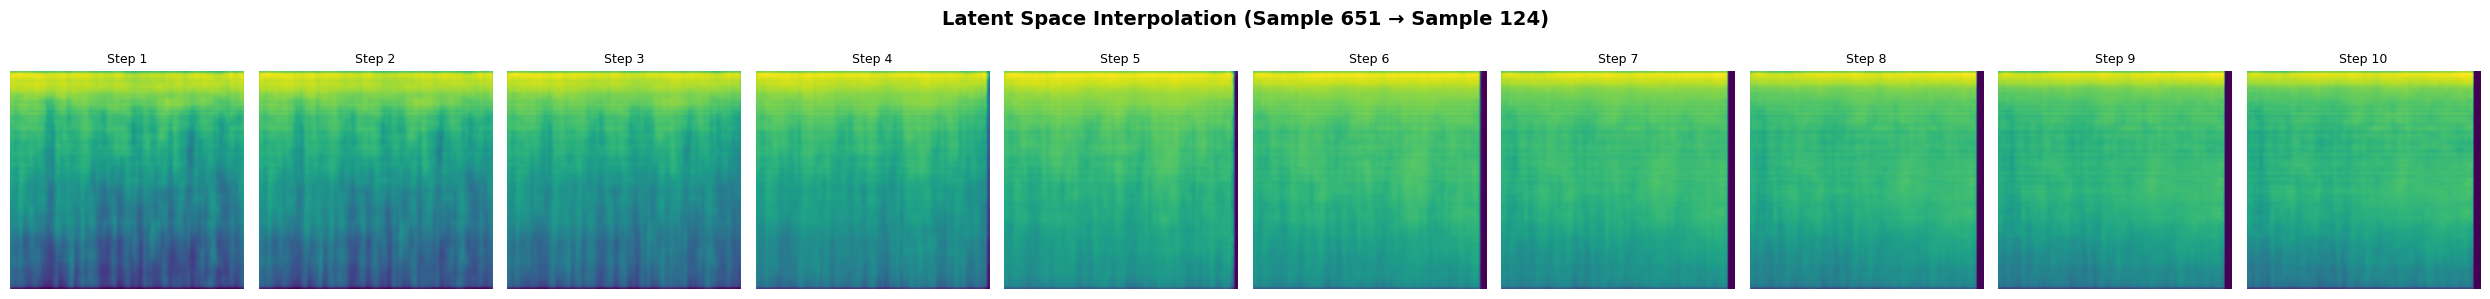

In [63]:
# ========================================
# CELL 21: Latent Space Interpolation
# ========================================
print("\n" + "=" * 60)
print("LATENT SPACE INTERPOLATION")
print("=" * 60)

# Select two samples
idx1, idx2 = np.random.choice(len(z_mean_spec), 2, replace=False)
z1 = z_mean_spec[idx1]
z2 = z_mean_spec[idx2]

# Interpolate in latent space
n_steps = 10
interpolation = np.zeros((n_steps, latent_dim))
for i in range(n_steps):
    alpha = i / (n_steps - 1)
    interpolation[i] = (1 - alpha) * z1 + alpha * z2

# Decode interpolated latents
interpolated_specs = conv_decoder.predict(interpolation, verbose=0)

# Visualize interpolation
fig, axes = plt.subplots(1, n_steps, figsize=(25, 3))
for i in range(n_steps):
    axes[i].imshow(interpolated_specs[i, :, :, 0], aspect='auto', cmap='viridis')
    axes[i].set_title(f'Step {i+1}', fontsize=9)
    axes[i].axis('off')

plt.suptitle(f'Latent Space Interpolation (Sample {idx1} → Sample {idx2})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/latent_interpolation.png', dpi=300, bbox_inches='tight')
plt.show()


CLUSTER DISTRIBUTION ANALYSIS


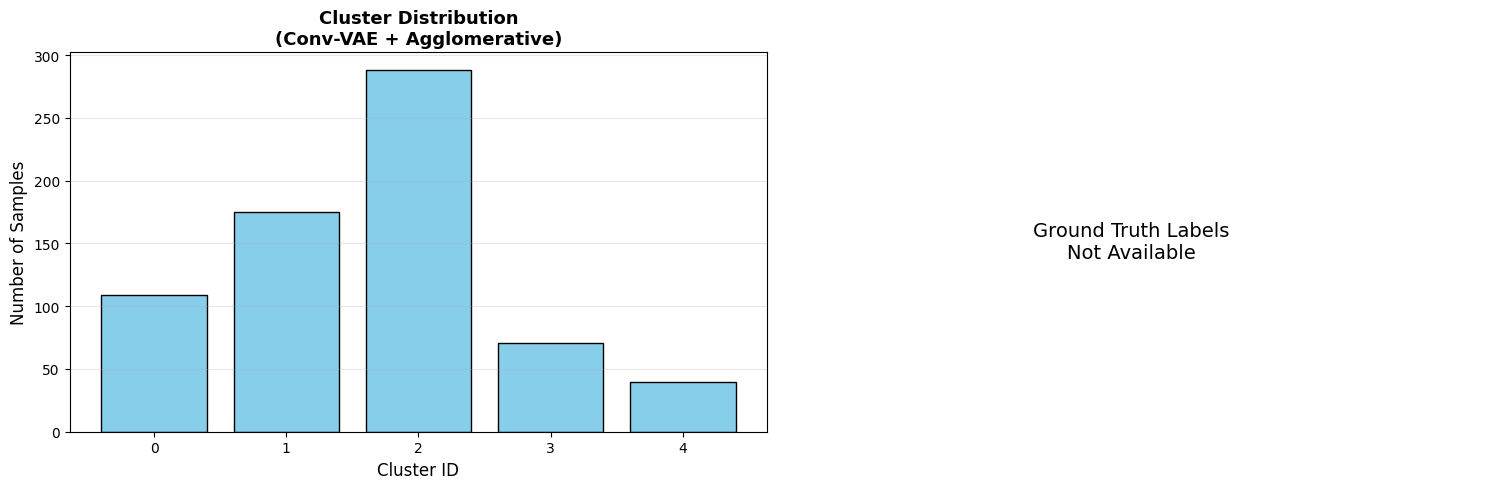

In [64]:
# ========================================
# CELL 22: Cluster Distribution Analysis
# ========================================
print("\n" + "=" * 60)
print("CLUSTER DISTRIBUTION ANALYSIS")
print("=" * 60)

# Use best overall method
best_feat = best_overall['Feature_Set']
best_algo = best_overall['Algorithm']
best_features = feature_sets[best_feat]

# Get clusters
if best_algo == 'K-Means':
    final_algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
elif best_algo == 'Agglomerative':
    final_algo = AgglomerativeClustering(n_clusters=n_clusters)
else:
    final_algo = DBSCAN(eps=0.5, min_samples=5)

final_clusters = final_algo.fit_predict(best_features)

# Plot cluster distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Cluster sizes
cluster_counts = pd.Series(final_clusters).value_counts().sort_index()
axes[0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Cluster ID', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title(f'Cluster Distribution\n({best_feat} + {best_algo})', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# If labels available, show cluster vs label distribution
if true_labels is not None:
    confusion_matrix = pd.crosstab(final_clusters, true_labels)
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Count'})
    axes[1].set_xlabel('True Labels', fontsize=12)
    axes[1].set_ylabel('Cluster ID', fontsize=12)
    axes[1].set_title('Cluster vs True Label Distribution', fontsize=13, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'Ground Truth Labels\nNot Available',
                ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
    axes[1].axis('off')

plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [69]:
# # ========================================
# # CELL 23: Download Results Folder
# # ========================================
# import shutil
# from google.colab import files

# # Define the path to the results folder and the output zip file
# results_folder_path = base_path + 'results'
# output_zip_path = base_path + 'results_archive'

# print(f"\nZipping folder: {results_folder_path} to {output_zip_path}.zip")

# # Create a zip archive of the results folder
# shutil.make_archive(output_zip_path, 'zip', results_folder_path)

# print("\nDownload your results_archive.zip file from the files sidebar.\n")

# # Optional: Provide a direct download link (might not work in all environments)
# # files.download(output_zip_path + '.zip')



Preparing to zip results (excluding models)...
  - Copied: visualizations
  - Copied: latent_features_hybrid.npy
  - Skipping 'models' directory: /content/results/models
  - Copied: latent_features_conv.npy
  - Copied: report_summary.txt
  - Copied: analysis_report.txt
  - Copied: metrics

Zipping prepared results to /content/results_archive.zip

Download your results_archive.zip file from the files sidebar.

Cleaned up temporary directory: /content/temp_results_for_zip
